In [1]:

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from sklearn.neural_network import MLPClassifier
import pickle
import cv2


# Just to make sure all the out puts get printed in individual jupyter cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"

In [2]:
raw_data = pd.read_pickle("train.pickle")
raw_data_valid = pd.read_pickle("valid.pickle")
raw_data_test = pd.read_pickle("test.pickle")
classes = pd.read_csv("label_names.csv", index_col=0)
sign_list = list(classes['SignName'])
sign_dictionary = { i : sign_list[i] for i in range(43)}


In [3]:
raw_data.keys()
coords = raw_data['coords']
labels = raw_data['labels']
features = raw_data['features']
sizes = raw_data['sizes']

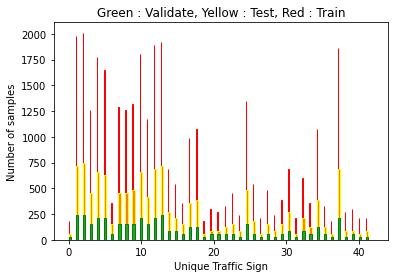

In [4]:
plt.hist(raw_data['labels'], bins=43, edgecolor='red', width=0.05)
plt.hist(raw_data_test['labels'], bins=43, edgecolor='yellow', width=0.3)
plt.hist(raw_data_valid['labels'], bins=43, edgecolor='green', width=0.3)
plt.title('Green : Validate, Yellow : Test, Red : Train')
plt.xlabel('Unique Traffic Sign')
plt.ylabel('Number of samples')
plt.show()



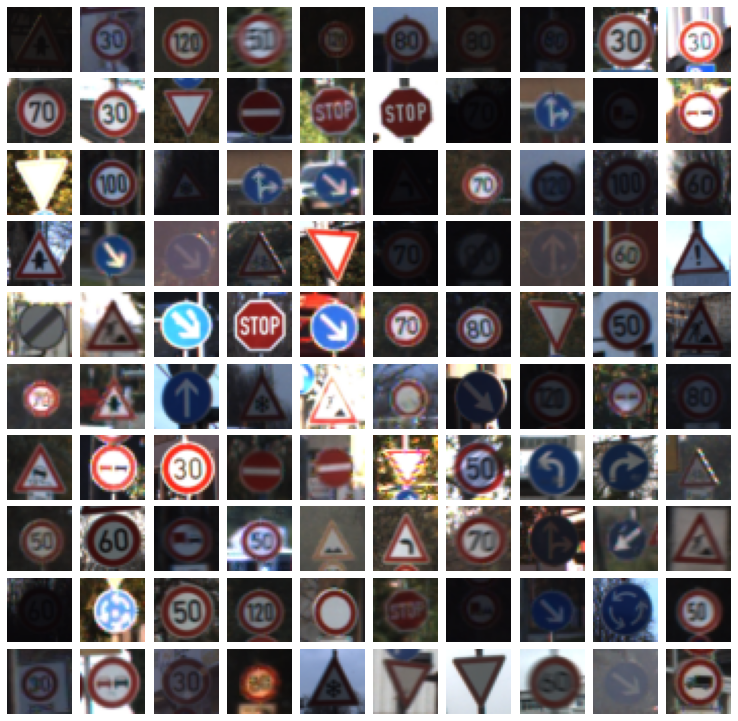

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize = (13,13))
grid = gridspec.GridSpec(10,10)
grid.update(wspace=0.1, hspace=0.1)  

for i in range(100):
    img_plt = plt.subplot(grid[i])
    rand = random.randint(0, len(features))
    plt.imshow(features[rand])
    plt.axis('off')

plt.show()

In [6]:
y_train = []
for i in range(len(labels)) :
    tmp = [ 0 for i in range(43) ]
    tmp[labels[i]] = 1
    y_train.append(tmp)
y_train = np.array(y_train)
x_train = features
print(y_train.shape)
initialW = tf.keras.initializers.RandomUniform(minval=-1, maxval=1, seed=None)


(34799, 43)


In [7]:
y_valid = []
for i in range(len(raw_data_valid['labels'])) :
    tmp = [ 0 for i in range(43) ]
    tmp[raw_data_valid['labels'][i]] = 1
    y_valid.append(tmp)
y_valid = np.array(y_valid)
x_valid = raw_data_valid['features']
print(y_valid.shape)


(4410, 43)


In [8]:
y_test = []
for i in range(len(raw_data_test['labels'])) :
    tmp = [ 0 for i in range(43) ]
    tmp[raw_data_test['labels'][i]] = 1
    y_test.append(tmp)
y_test = np.array(y_test)
x_test = raw_data_test['features']
print(y_test.shape)

(12630, 43)


In [9]:
palette = plt.get_cmap('Set2')
plt.style.use('seaborn-darkgrid')


LETS TRY SOME MODIFICAION !!!!

(34799, 32, 32, 1)

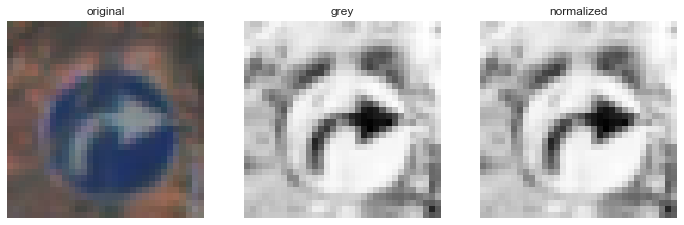

In [10]:
def cvtGrey(img):
    img_grey = np.sum(img/3, axis=3, keepdims=True)
    return img_grey


x_train_grey = cvtGrey(x_train)
x_valid_grey = cvtGrey(x_valid)
x_test_grey = cvtGrey(x_test)



def normalize(img):
    img_normalized = (img - 128) / 128
    return img_normalized

x_train_normalized = normalize(x_train_grey)
x_valid_normalized = normalize(x_valid_grey)
x_test_normalized = normalize(x_test_grey)




index = 26531    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,11))
ax1.axis('off')
ax1.imshow(x_train[index].squeeze())
ax1.set_title('original')

ax2.axis('off')
ax2.imshow(x_train_grey[index].squeeze())
ax2.set_title('grey')

ax3.axis('off')
ax3.imshow(x_train_normalized[index].squeeze())
ax3.set_title('normalized')


x_train_normalized.shape

Text(0.5, 1.0, 'zoom 1.25')

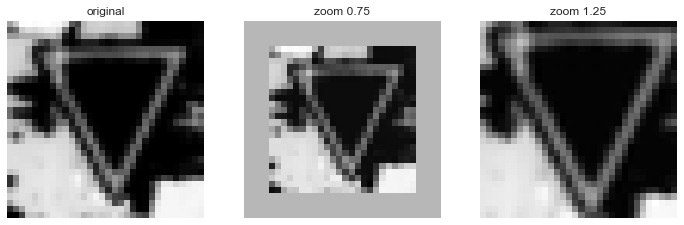

In [11]:
import numpy as np
from scipy.ndimage import zoom


def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out


oo = clipped_zoom(x_train_normalized[23450] , 1.25)
ooo = clipped_zoom(x_train_normalized[23450] , 0.75)
o = x_train_normalized[23450]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,11))
ax1.axis('off')
ax1.imshow(o.squeeze())
ax1.set_title('original')

ax2.axis('off')
ax2.imshow(ooo.squeeze())
ax2.set_title('zoom 0.75')

ax3.axis('off')
ax3.imshow(oo.squeeze())
ax3.set_title('zoom 1.25')

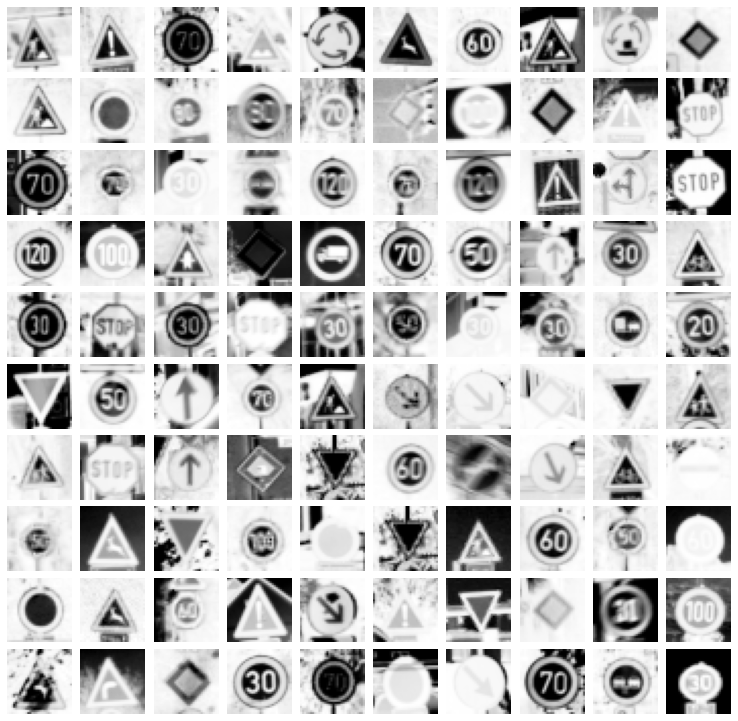

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize = (13,13))
grid = gridspec.GridSpec(10,10)
grid.update(wspace=0.1, hspace=0.1)  

for i in range(100):
    img_plt = plt.subplot(grid[i])
    rand = random.randint(0, len(x_train_normalized))
    plt.imshow(x_train_normalized[rand])
    plt.axis('off')

plt.show()

AUGMENTING

In [13]:
x_valid_normalized.shape

(4410, 32, 32, 1)

In [14]:
from skimage import exposure

new_data_train = x_train_normalized
new_data_valid = x_valid_normalized

new_data_train = new_data_train.reshape(34799, 32, 32)
new_data_valid = new_data_valid.reshape(4410, 32, 32)


for i in range(len(new_data_train)) : 
    new_data_train[i] = exposure.equalize_hist(new_data_train[i])
new_data_train = np.array(new_data_train)

for i in range(len(new_data_valid)) :
    new_data_valid[i] = exposure.equalize_hist(new_data_valid[i])
new_data_valid = np.array(new_data_valid)

new_data_train = new_data_train.reshape(34799, 32, 32, 1)
new_data_valid = new_data_valid.reshape(4410, 32, 32, 1)
print(new_data_valid.shape, new_data_train.shape)

(4410, 32, 32, 1) (34799, 32, 32, 1)


In [15]:
x_aug_zoom = []
y_aug_zoom = []

for i in range(34799) :
  
  #if label_count[labels[i]] <= 1000 :

  
    y_tmp = [0 for j in range(43)]
    y_tmp[labels[i]] = 1
    
    # adding zoom
    x_aug_zoom.append( clipped_zoom(new_data_train[i], 1.25) )
    x_aug_zoom.append( clipped_zoom(new_data_train[i], 0.75) )
    x_aug_zoom.append( new_data_train[i] )
    y_aug_zoom.append( y_tmp ) 
    y_aug_zoom.append( y_tmp ) 
    y_aug_zoom.append( y_tmp )


x_aug_zoom = np.array(x_aug_zoom)
y_aug_zoom = np.array(y_aug_zoom)
print(x_aug_zoom.shape, y_aug_zoom.shape)

(104397, 32, 32, 1) (104397, 43)


In [16]:
x_aug_zoom_valid = []
y_aug_zoom_valid = []

for i in range(4410) :
  
  #if label_count[labels[i]] <= 1000 :

    
    # adding zoom
    x_aug_zoom_valid.append( clipped_zoom(new_data_valid[i], 1.25) )
    x_aug_zoom_valid.append( clipped_zoom(new_data_valid[i], 0.75) )
    x_aug_zoom_valid.append( new_data_valid[i] )
    y_aug_zoom_valid.append( y_valid[i] ) 
    y_aug_zoom_valid.append( y_valid[i] ) 
    y_aug_zoom_valid.append( y_valid[i] ) 

x_aug_zoom_valid = np.array(x_aug_zoom_valid)
y_aug_zoom_valid = np.array(y_aug_zoom_valid)
print(x_aug_zoom_valid.shape, y_aug_zoom_valid.shape)

(13230, 32, 32, 1) (13230, 43)


FAQAT MOONDE NOISE BENDAZIM ROOYE AUGMENTED VA DOBARE KHOROOJI BEGIRIM SHAYAD BE 99 HAM BERESE

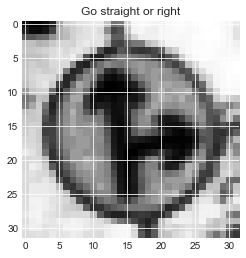

In [17]:
yyy = 500
plt.imshow(x_aug_zoom_valid[yyy])
plt.title( sign_dictionary[list(y_aug_zoom_valid[yyy]).index(1)] )
plt.show()


LAST AUGMENT Y_LINES

In [18]:
import cv2

x_aug_filter = []
y_aug_filter = []

x_aug_filter_valid = []
y_aug_filter_valid = []

mat_y = np.array([[ -1, -2, -1], [ 0, 0, 0], [ 1, 2, 1]])

for i in range(34799) :

    y_tmp = [0 for j in range(43)]
    y_tmp[labels[i]] = 1

    
    x_aug_filter.append( cv2.filter2D(new_data_train[i], -1, mat_y) )
    y_aug_filter.append( y_tmp ) 
    


for i in range(4410) :
    

    
    x_aug_filter_valid.append( cv2.filter2D(new_data_valid[i], -1, mat_y) )
    y_aug_filter_valid.append( y_valid[i] ) 
       




x_aug_filter = np.array(x_aug_filter)
y_aug_filter = np.array(y_aug_filter)
x_aug_filter_valid = np.array(x_aug_filter_valid)
y_aug_filter_valid = np.array(y_aug_filter_valid)
print(x_aug_filter.shape, x_aug_filter_valid.shape)
print(y_aug_filter.shape, y_aug_filter_valid.shape)


(34799, 32, 32) (4410, 32, 32)
(34799, 43) (4410, 43)


In [19]:
x_aug_filter = x_aug_filter.reshape(34799, 32, 32, 1)
x_aug_filter_valid = x_aug_filter_valid.reshape(4410, 32, 32, 1)
print(x_aug_filter.shape, x_aug_filter_valid.shape)

(34799, 32, 32, 1) (4410, 32, 32, 1)


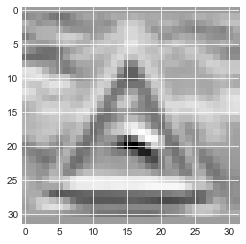

In [20]:
xxxx = 620

plt.imshow(x_aug_filter[xxxx])
plt.show()

ADDING NOISE

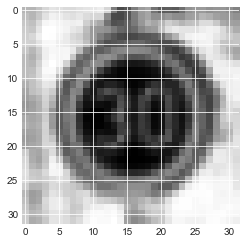

In [21]:
plt.imshow(new_data_train[3342])
plt.show()

Text(0.5, 1.0, 'noised example 2')

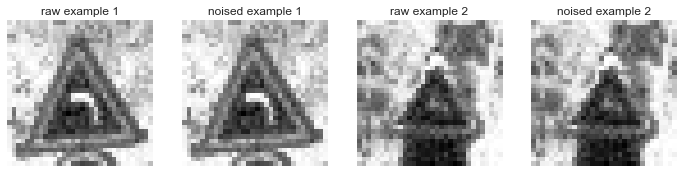

In [22]:
mean = 0.0   # some constant
std = 0.05    # some constant (standard deviation)

x_aug_noise = new_data_train
x_aug_noise_valid = new_data_valid
y_aug_noise = y_train
y_aug_noise_valid = y_valid

for i in range(len(new_data_train)) :
    img = new_data_train[i]
    noisy_img = img + np.random.normal(mean, std, img.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)  # we might get out of bounds due to noise
    x_aug_noise[i] = noisy_img_clipped

for i in range(len(new_data_valid)) :
    img = new_data_valid[i]
    noisy_img = img + np.random.normal(mean, std, img.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)  
    x_aug_noise_valid[i] = noisy_img_clipped



aaa = x_aug_noise[6653]
aa = new_data_train[6653]
aaaaa = x_aug_noise[213]
aaaa = new_data_train[213]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12,11))
ax1.axis('off')
ax1.imshow(aa)
ax1.set_title('raw example 1')

ax2.axis('off')
ax2.imshow(aaa)
ax2.set_title('noised example 1')

ax3.axis('off')
ax3.imshow(aaaa)
ax3.set_title('raw example 2')

ax4.axis('off')
ax4.imshow(aaaaa)
ax4.set_title('noised example 2')


ADDING ALL THE DATA TOGHETER

In [23]:
final_x_train = np.concatenate((x_aug_zoom, x_aug_filter, x_aug_noise), axis=0)
final_y_train = np.concatenate((y_aug_zoom, y_aug_filter, y_aug_noise), axis=0)
final_x_valid = np.concatenate((x_aug_zoom_valid, x_aug_filter_valid, x_aug_noise_valid), axis=0)
final_y_valid = np.concatenate((y_aug_zoom_valid, y_aug_filter_valid, y_aug_noise_valid), axis=0)


print(final_x_train.shape, final_y_train.shape)
print(final_x_valid.shape, final_y_valid.shape)

(173995, 32, 32, 1) (173995, 43)
(22050, 32, 32, 1) (22050, 43)


Epoch 1/5
2719/2719 [==============================] - 169s 62ms/step - loss: 0.7404 - accuracy: 0.7880 - val_loss: 0.4064 - val_accuracy: 0.9032
Epoch 2/5
2719/2719 [==============================] - 172s 63ms/step - loss: 0.2801 - accuracy: 0.9151 - val_loss: 0.2567 - val_accuracy: 0.9393
Epoch 3/5
2719/2719 [==============================] - 172s 63ms/step - loss: 0.2165 - accuracy: 0.9338 - val_loss: 0.2359 - val_accuracy: 0.9427
Epoch 4/5
2719/2719 [==============================] - 166s 61ms/step - loss: 0.1844 - accuracy: 0.9428 - val_loss: 0.1856 - val_accuracy: 0.9541
Epoch 5/5
2719/2719 [==============================] - 170s 62ms/step - loss: 0.1652 - accuracy: 0.9494 - val_loss: 0.1807 - val_accuracy: 0.9527
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        320       
__________________________________________________

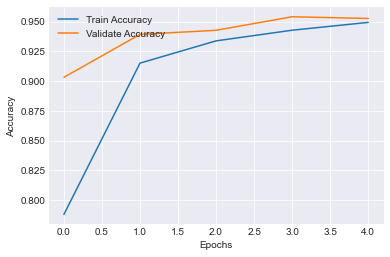

In [33]:

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
network = Sequential()


epoch_num = 5
input_shape = (32, 32, 3)

network.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), padding='same'))
network.add(layers.Dropout(0.25))
network.add(layers.MaxPooling2D((2, 2)))

network.add(layers.Conv2D(64, (3, 3), activation='relu'))
network.add(layers.Dropout(0.25))
network.add(layers.MaxPooling2D((2, 2)))


network.add(layers.Flatten())
#network.add(layers.Dense(400, activation='relu'))
network.add(layers.Dropout(0.5))
network.add(layers.Dense(43, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = network.fit(final_x_train, final_y_train, validation_data=(final_x_valid, final_y_valid), epochs=epoch_num, batch_size=64)







#-------------------------------------------------------------------PLOTTING---------------------------------------------------------------------



plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Validate Accuracy'], loc='upper left')

network.summary()

In [40]:
weights = network.get_weights()

import pickle
try:
    fpkl= open('weightsFile', 'wb')    #Python 3     
    pickle.dump(weights, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()
except:
    fpkl= open('weightsFile', 'w')    #Python 2      
    pickle.dump(weights, fpkl, protocol= pickle.HIGHEST_PROTOCOL)
    fpkl.close()